In [219]:
import pandas as pd
import seaborn as sns
sns.set_context("talk")
sns.set_style("white")

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

df = pd.read_csv("endpoints_2.csv")
df = df[np.logical_not(np.in1d(df["catch"],["chiyabi","manchanvwa"]))]
cm = pd.read_csv("calib_map_eye.csv")

df["int_type"] = "All"
df.loc[np.logical_not(df["itn"]),"int_type"] = "No ITN"
df.loc[np.logical_not(df["irs"]),"int_type"] = "No IRS"
df.loc[np.logical_not(df["mda"]),"int_type"] = "No MDA"
df.loc[np.logical_not(df["chw_rcd"]),"int_type"] = "No CHW RCD"
df.loc[np.logical_not(df["chw_hs"]),"int_type"] = "No CHW HS"
df.loc[np.logical_and(np.logical_not(df["chw_rcd"]),np.logical_not(df["chw_hs"])) ,"int_type"] = "No CHW"

cm.rename(columns={"annual_EIR": "historical_annual_EIR","avg_prev": "historical_avg_prev"}, inplace=True)
df = df.merge(cm[["historical_annual_EIR","historical_avg_prev", "catch","sample"]], how="left", on=["catch","sample"])


# Catchments in parameter space:
cdf = df[["catch","sample","arab","funest"]].groupby(["catch","sample"]).median()
cdf.reset_index(inplace=True)

all_df = df[df["int_type"]=="All"]
all_df.rename(columns={"EIR": "EIR_allint",
                      "RDT_prev": "RDT_prev_allint",
                      "cases": "cases_allint"},
             inplace=True)

int_dict = {}
int_dict_2 = {}
for k in ["No ITN", "No IRS", "No MDA", "No CHW", "No CHW HS", "No CHW RCD"]:
    int_dict[k] = df[df["int_type"]==k]
    
    int_dict[k] = int_dict[k].merge(all_df[["catch","sample","Run_Number","EIR_allint","RDT_prev_allint","cases_allint"]],
                                    on=["catch","sample","Run_Number"])
    
#     for j in ["EIR", "RDT_prev","cases"]:
#         int_dict[k]["abs_diff_{}".format(j)] = -int_dict[k]["{}_allint".format(j)]+int_dict[k][j]
#         int_dict[k]["rel_diff_{}".format(j)] = int_dict[k]["abs_diff_{}".format(j)]/int_dict[k]["historical"]
    j = "EIR"
    int_dict[k]["abs_diff_{}".format(j)] = -int_dict[k]["{}_allint".format(j)]+int_dict[k][j]
    int_dict[k]["rel_diff_{}".format(j)] = int_dict[k]["abs_diff_{}".format(j)]/(int_dict[k]["historical_annual_EIR"]-int_dict[k]["EIR_allint"])
    
    
    int_dict[k] = int_dict[k].groupby(["catch","sample"]).agg("median")
    int_dict[k].reset_index(inplace=True)
    int_dict[k]["intervention"] = k[3:]
    
    int_dict_2[k] = int_dict[k].groupby("catch").agg("median").reset_index()
    t = int_dict[k].groupby("catch").agg({"rel_diff_EIR":"std"}).reset_index()
    t.rename(columns={"rel_diff_EIR": "rel_diff_EIR_std"}, inplace=True)
    int_dict_2[k] = int_dict_2[k].merge(t,on="catch")
    
    

# label_point(df_iris.sepal_length, df_iris.sepal_width, df_iris.species, plt.gca())  

c:\users\jsuresh\appdata\local\programs\python\python36\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [296]:
def label_point(x, y, val, ax, x_offset=0.02, y_offset=0):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+x_offset, point['y']+y_offset, str(point['val']))


In [276]:
cov_df = pd.read_csv("catch_coverages.csv")
my_catch_list = list(set(cdf["catch"]))

cov_df = cov_df[np.in1d(cov_df["catch"], my_catch_list)]
# cov_df = cdf[["catch"]].merge(cov_df, how="left",on="catch")
cov_df.reset_index(inplace=True, drop=True)

cov_df["mda_metric_1"] = np.sqrt(cov_df["mda_med_cov"]*cov_df["mda_max_cov"])
cov_df["mda_metric_2"] = np.sqrt(cov_df["mda_total_cov"]*cov_df["mda_max_cov"])
cov_df["mda_bin"] = "none"
MDA_thresh = np.median(cov_df["mda_metric_1"])
cov_df.loc[cov_df["mda_metric_1"] < MDA_thresh, "mda_bin"] = "low"
cov_df.loc[cov_df["mda_metric_1"] >= MDA_thresh, "mda_bin"] = "high"


cov_df["itn_bin"] = "none"
ITN_thresh = np.median(cov_df["itn_integrated_cov"])
cov_df.loc[cov_df["itn_integrated_cov"] < ITN_thresh, "itn_bin"] = "low"
cov_df.loc[cov_df["itn_integrated_cov"] >= ITN_thresh, "itn_bin"] = "high"

cov_df["irs_bin"] = "none"
# some_IRS = cov_df["irs_max_kill"] >= 0.15
some_IRS = cov_df["irs_integrated_cov"] >= 140
IRS_thresh1 = 140
# IRS_thresh = np.median(cov_df["irs_integrated_cov"][some_IRS])
IRS_thresh2 = 560 # derived visually
cov_df.loc[np.logical_and(cov_df["irs_integrated_cov"] < IRS_thresh2, some_IRS), "irs_bin"] = "low"
cov_df.loc[cov_df["irs_integrated_cov"] >= IRS_thresh2, "irs_bin"] = "high"

cov_df["vc_bin"] = 0
cov_df.loc[np.logical_and(cov_df["itn_bin"] == "low", cov_df["irs_bin"] == "none"), "vc_bin"] = 0

cov_df.loc[np.logical_and(cov_df["itn_bin"] == "high", cov_df["irs_bin"] == "none"), "vc_bin"] = 1
cov_df.loc[np.logical_and(cov_df["itn_bin"] == "low", cov_df["irs_bin"] == "low"), "vc_bin"] = 1

cov_df.loc[np.logical_and(cov_df["itn_bin"] == "high", cov_df["irs_bin"] == "low"), "vc_bin"] = 2
cov_df.loc[np.logical_and(cov_df["itn_bin"] == "low", cov_df["irs_bin"] == "high"), "vc_bin"] = 2

cov_df.loc[np.logical_and(cov_df["itn_bin"] == "high", cov_df["irs_bin"] == "high"), "vc_bin"] = 3

cov_df["vc_integrated_kill"] = cov_df["itn_integrated_kill"] + cov_df["irs_integrated_kill"]


In [52]:
catch_wo_IRS = list(set(cov_df["catch"][cov_df["irs_bin"]=="none"]))
a = int_dict["No MDA"].copy(deep=True)
# plt.scatter(int_dict["No IRS"]["historical_annual_EIR"],int_dict["No IRS"]["abs_diff_EIR"]
temp = a[a["historical_annual_EIR"]<50]
plt.figure(figsize=(15,15))
sns.scatterplot(x="mda_med_cov",y="abs_diff_EIR",hue="catch",size="historical_annual_EIR",data=temp)
# plt.ylim([-50,0])
# plt.xscale('log')

ValueError: Could not interpret input 'mda_med_cov'

<Figure size 1080x1080 with 0 Axes>

In [53]:
catch_wo_IRS = list(set(cov_df["catch"][cov_df["irs_bin"]=="none"]))

In [54]:
catch_wo_IRS

['siameja', 'luyaba', 'mtendere', 'bbondo', 'jamba']

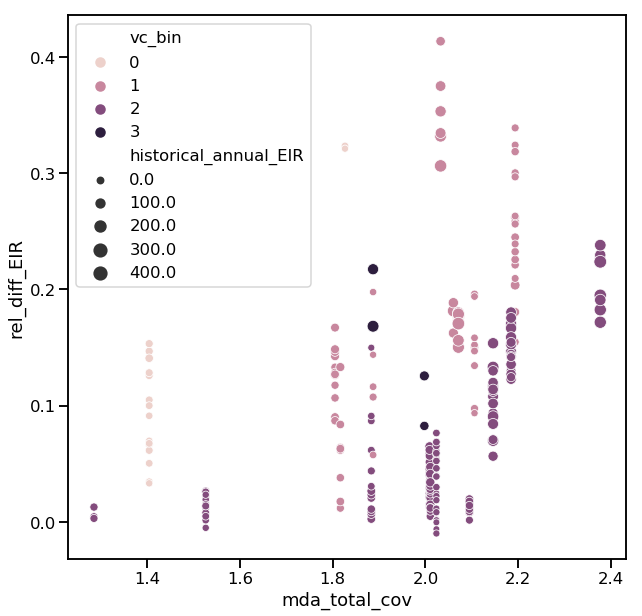

In [101]:
plt.figure(figsize=(10,10))
foo = cov_df.merge(int_dict["No MDA"],on="catch",how="left")
sns.scatterplot("mda_total_cov","rel_diff_EIR",data=foo,hue="vc_bin", size="historical_annual_EIR")

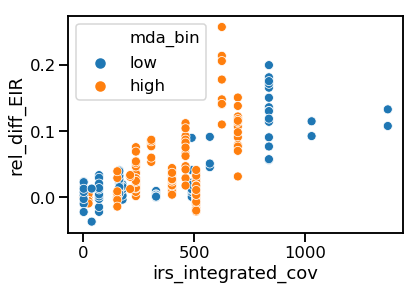

In [86]:
foo = cov_df.merge(int_dict["No IRS"],on="catch",how="left")
sns.scatterplot("irs_integrated_cov","rel_diff_EIR",data=foo, hue="mda_bin")

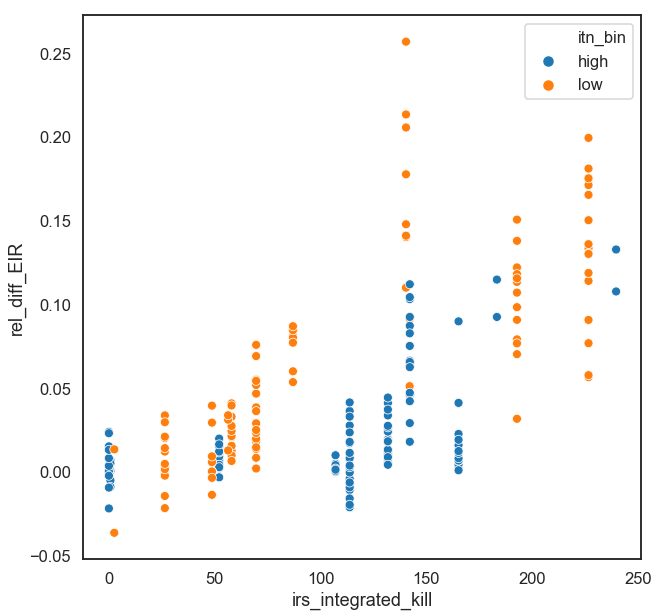

In [217]:
plt.figure(figsize=(10,10))
foo = cov_df.merge(int_dict["No IRS"],on="catch",how="left")
sns.scatterplot("irs_integrated_kill","rel_diff_EIR",data=foo, hue="itn_bin") #, style="mda_bin"

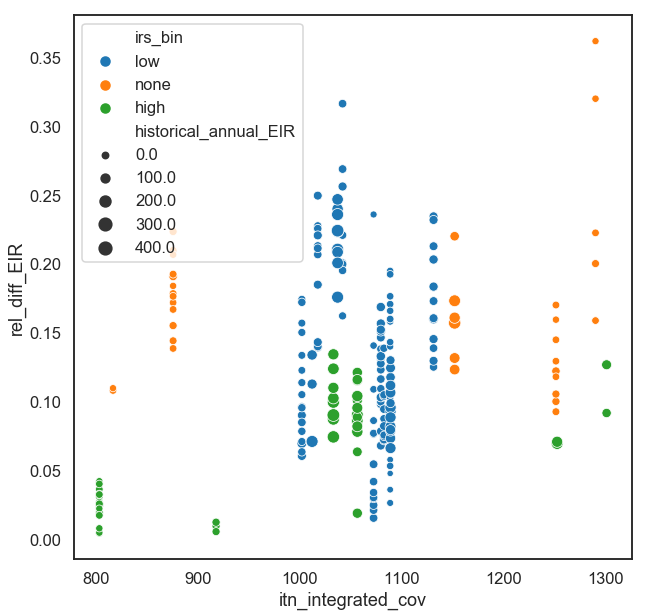

In [218]:
plt.figure(figsize=(10,10))
foo = cov_df.merge(int_dict["No ITN"],on="catch",how="left")
sns.scatterplot("itn_integrated_cov","rel_diff_EIR",data=foo, hue="irs_bin", size="historical_annual_EIR")

(0, 0.35)

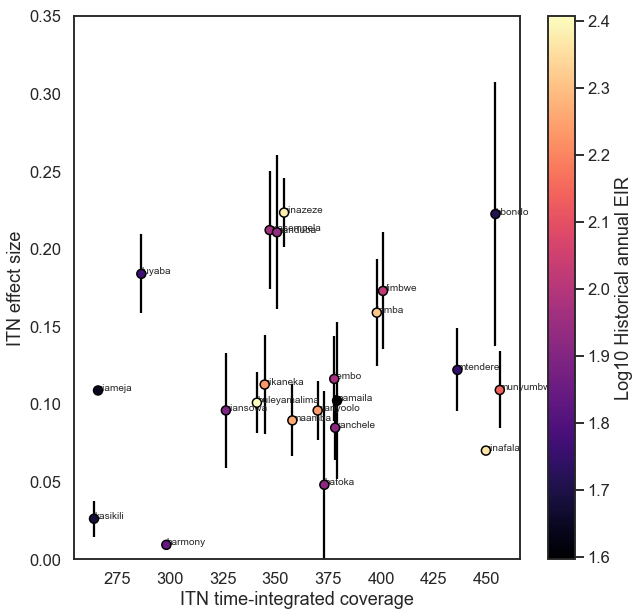

In [214]:
plt.figure(figsize=(10,10))
foo = cov_df.merge(int_dict_2["No ITN"],on="catch",how="left")
plt.scatter(foo["itn_integrated_kill"],foo["rel_diff_EIR"],c=np.log10(foo["historical_annual_EIR"]),edgecolors='black',linestyle='None',cmap='magma',zorder=5)
plt.colorbar(label="Log10 Historical annual EIR")

plt.errorbar(foo["itn_integrated_kill"],foo["rel_diff_EIR"],yerr=foo["rel_diff_EIR_std"],linestyle='None',color='black')
label_point(foo.itn_integrated_kill, foo.rel_diff_EIR, foo.catch, plt.gca())
plt.xlabel("ITN time-integrated coverage")
plt.ylabel("ITN effect size")
plt.ylim([0,0.35])

(0, 0.22)

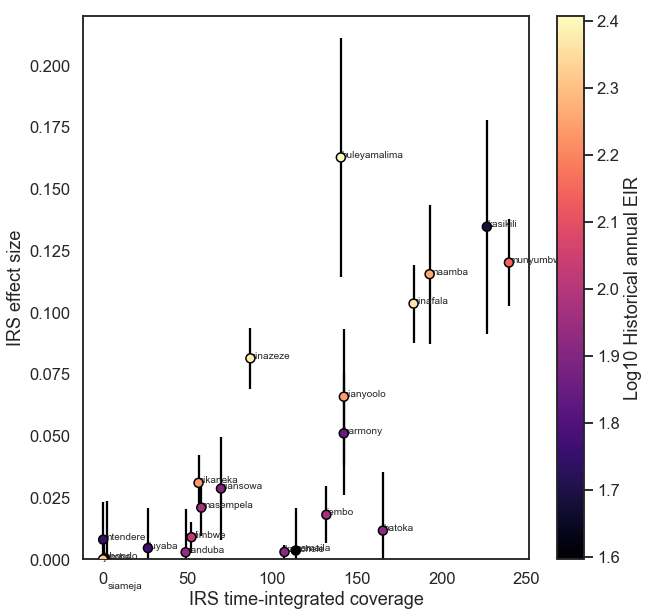

In [215]:
plt.figure(figsize=(10,10))
foo = cov_df.merge(int_dict_2["No IRS"],on="catch",how="left")
# sns.scatterplot("irs_integrated_kill","rel_diff_EIR",data=foo,zorder=5)
plt.scatter(foo["irs_integrated_kill"],foo["rel_diff_EIR"],c=np.log10(foo["historical_annual_EIR"]),edgecolors='black',linestyle='None',cmap='magma',zorder=5)
plt.colorbar(label="Log10 Historical annual EIR")

plt.errorbar(foo["irs_integrated_kill"],foo["rel_diff_EIR"],yerr=foo["rel_diff_EIR_std"],linestyle='None',color='black')
label_point(foo.irs_integrated_kill, foo.rel_diff_EIR, foo.catch, plt.gca())
plt.xlabel("IRS time-integrated coverage")
plt.ylabel("IRS effect size")
plt.ylim([0,0.22])

(0, 0.4)

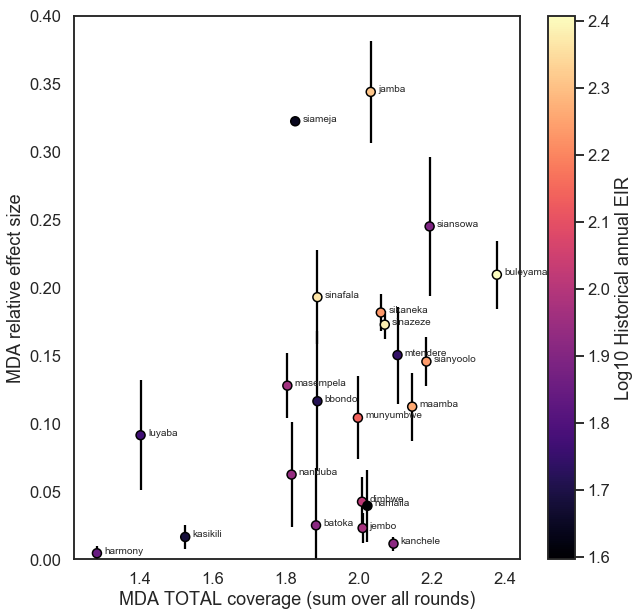

In [216]:
plt.figure(figsize=(10,10))
foo = cov_df.merge(int_dict_2["No MDA"],on="catch",how="left")
# sns.scatterplot("mda_total_cov","rel_diff_EIR",data=foo,zorder=5,hue="irs_max_kill")
plt.scatter(foo["mda_total_cov"],foo["rel_diff_EIR"],c=np.log10(foo["historical_annual_EIR"]),edgecolors='black',linestyle='None',cmap='magma',zorder=5)
plt.colorbar(label="Log10 Historical annual EIR")
plt.errorbar(foo["mda_total_cov"],foo["rel_diff_EIR"],yerr=foo["rel_diff_EIR_std"],linestyle='None',color='black')
label_point(foo.mda_total_cov, foo.rel_diff_EIR, foo.catch, plt.gca())
plt.xlabel("MDA TOTAL coverage (sum over all rounds)")
plt.ylabel("MDA relative effect size")
plt.ylim([0,0.4])

# CHW

In [277]:
chw_df = pd.read_csv("../slide_prep/chw_cov.csv")
cov_df = cov_df.merge(chw_df, how="left", on="catch")

In [272]:
cov_df

,catch,irs_integrated_cov,irs_integrated_kill,irs_max_cov,irs_max_kill,itn_integrated_block,itn_integrated_cov,itn_integrated_cov_eff,itn_integrated_kill,itn_max_block,...,irs_bin,vc_bin,vc_integrated_kill,diff_adult_effhs,diff_youth_effhs,post_adult_effhs,post_youth_effhs,pre_adult_effhs,pre_youth_effhs,trigger_coverage
0,batoka,488.383907,165.237963,0.802281,0.500990,455.194193,1072.431604,798.720684,373.168316,0.499375,...,low,2,538.406278,0.008441,0.016883,0.313954,0.627907,0.305512,0.611024,0.702469
1,bbondo,23.144125,0.745999,0.016449,0.008225,560.027906,1290.408878,958.692414,454.144490,0.557746,...,none,1,454.890489,0.076800,0.153601,0.357728,0.715457,0.280928,0.561856,0.702469
2,buleyamalima,624.086193,140.410313,0.831925,0.481341,404.402747,1032.949634,762.468345,341.224122,0.441775,...,high,2,481.634435,0.066361,0.132722,0.339889,0.679777,0.273528,0.547055,0.231748
3,dimbwe,176.368616,52.142247,0.297393,0.133706,496.226839,1131.332455,840.177951,400.896376,0.661348,...,low,2,453.038623,0.036836,0.073671,0.334340,0.668680,0.297504,0.595009,0.603333
4,harmony,569.978518,142.125243,0.810277,0.579208,349.833115,917.703763,680.835977,298.371484,0.436923,...,high,2,440.496727,0.012794,0.025589,0.369493,0.738986,0.356698,0.713397,0.702469
5,jamba,0.000000,0.000000,0.000000,0.000000,483.748117,1152.047013,851.933748,397.986240,0.458158,...,none,1,397.986240,0.073955,0.147909,0.350403,0.700806,0.276449,0.552897,0.603333
6,jembo,399.456062,131.847777,0.669230,0.394484,463.106487,1079.530301,799.992968,377.848247,0.566986,...,low,2,509.696024,0.022255,0.044510,0.281354,0.562709,0.259100,0.518199,0.676254
7,kanchele,327.572612,107.105696,0.606409,0.345698,463.898283,1082.577508,800.582274,378.288531,0.568377,...,low,2,485.394228,0.052600,0.105200,0.304574,0.609149,0.251974,0.503948,0.676254
8,kasikili,836.507090,226.641817,0.978780,0.585146,310.565796,803.051950,596.571089,264.137325,0.353163,...,high,2,490.779141,0.022503,0.045007,0.290752,0.581505,0.268249,0.536498,0.676254
9,luyaba,70.436887,26.465448,0.190797,0.145540,336.731771,875.509769,646.738251,286.535117,0.409322,...,none,0,313.000565,0.048798,0.097595,0.301345,0.602689,0.252547,0.505094,0.702469


Text(0.5, 0, 'Difference in u5 effective health-seeking rate from CHW addition')

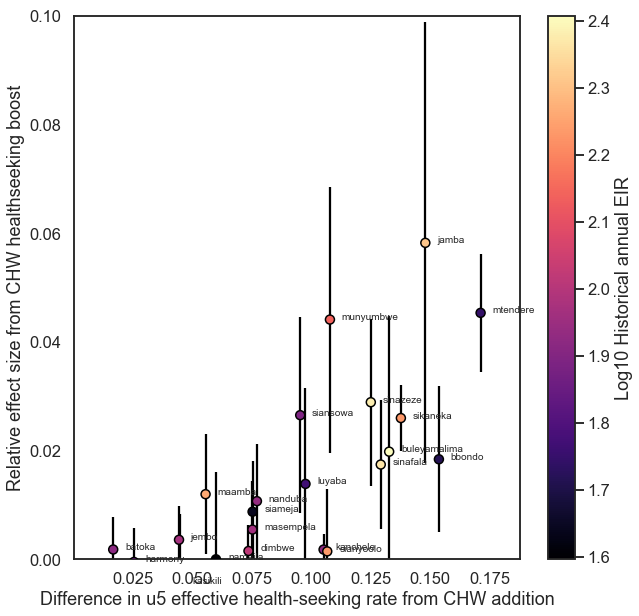

In [253]:
plt.figure(figsize=(10,10))
x = "diff_youth_effhs"
y = "rel_diff_EIR"
yerr = "rel_diff_EIR_std"
c = "historical_annual_EIR"

foo = cov_df.merge(int_dict_2["No CHW HS"],on="catch",how="left")
# sns.scatterplot("mda_total_cov","rel_diff_EIR",data=foo,zorder=5,hue="irs_max_kill")
plt.scatter(foo[x],foo[y],c=np.log10(foo[c]),edgecolors='black',linestyle='None',cmap='magma',zorder=5)
plt.colorbar(label="Log10 Historical annual EIR")
plt.errorbar(foo[x],foo[y],yerr=foo[yerr],linestyle='None',color='black')
label_point(foo.diff_youth_effhs, foo.rel_diff_EIR, foo.catch, plt.gca(),x_offset=0.005)
# plt.xlabel("MDA TOTAL coverage (sum over all rounds)")
plt.ylim([0,0.1])
plt.ylabel("Relative effect size from CHW healthseeking boost")
plt.xlabel("Difference in u5 effective health-seeking rate from CHW addition")

Text(0.5, 0, 'Effective RCD trigger rate (u5 health-seeking rate * CHW case coverage)')

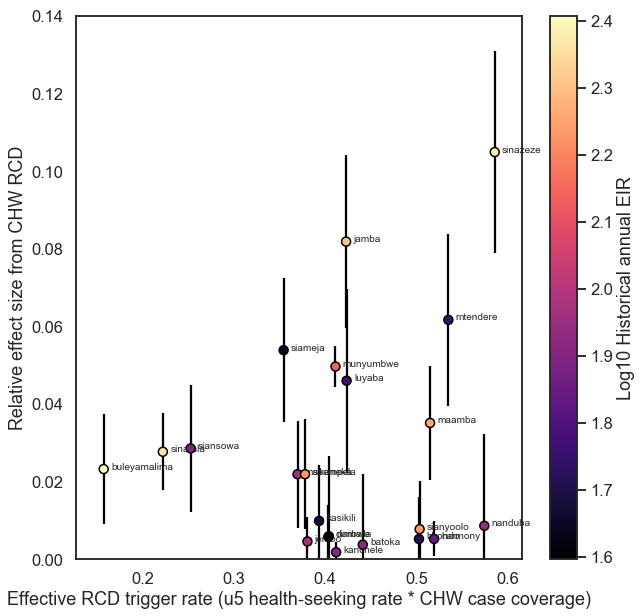

In [285]:
plt.figure(figsize=(10,10))
x = "rcd_trigger_youth"
y = "rel_diff_EIR"
yerr = "rel_diff_EIR_std"
c = "historical_annual_EIR"

foo = cov_df.merge(int_dict_2["No CHW RCD"],on="catch",how="left")
# sns.scatterplot("mda_total_cov","rel_diff_EIR",data=foo,zorder=5,hue="irs_max_kill")
plt.scatter(foo[x],foo[y],c=np.log10(foo[c]),edgecolors='black',linestyle='None',cmap='magma',zorder=5)
plt.colorbar(label="Log10 Historical annual EIR")
plt.errorbar(foo[x],foo[y],yerr=foo[yerr],linestyle='None',color='black')
label_point(foo.rcd_trigger_youth, foo.rel_diff_EIR, foo.catch, plt.gca(),x_offset=0.008)
plt.ylim([0,0.14])
plt.ylabel("Relative effect size from CHW RCD")
plt.xlabel("Effective RCD trigger rate (u5 health-seeking rate * CHW case coverage)")

Text(0.5, 0, 'u5 difference in health-seeking rate after adding CHW')

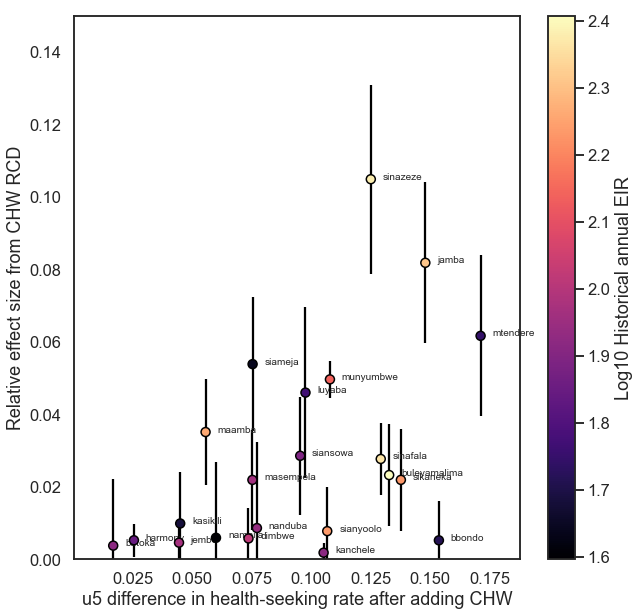

In [266]:
plt.figure(figsize=(10,10))
x = "diff_youth_effhs"
y = "rel_diff_EIR"
yerr = "rel_diff_EIR_std"
c = "historical_annual_EIR"

foo = cov_df.merge(int_dict_2["No CHW RCD"],on="catch",how="left")
# sns.scatterplot("mda_total_cov","rel_diff_EIR",data=foo,zorder=5,hue="irs_max_kill")
plt.scatter(foo[x],foo[y],c=np.log10(foo[c]),edgecolors='black',linestyle='None',cmap='magma',zorder=5)
plt.colorbar(label="Log10 Historical annual EIR")
plt.errorbar(foo[x],foo[y],yerr=foo[yerr],linestyle='None',color='black')
label_point(foo.diff_youth_effhs, foo.rel_diff_EIR, foo.catch, plt.gca(),x_offset=0.005)
# plt.xlabel("MDA TOTAL coverage (sum over all rounds)")
plt.ylim([0,0.15])
plt.ylabel("Relative effect size from CHW RCD")
plt.xlabel("u5 difference in health-seeking rate after adding CHW")

Text(0.5, 0, 'Difference in u5 effective health-seeking rate from CHW addition')

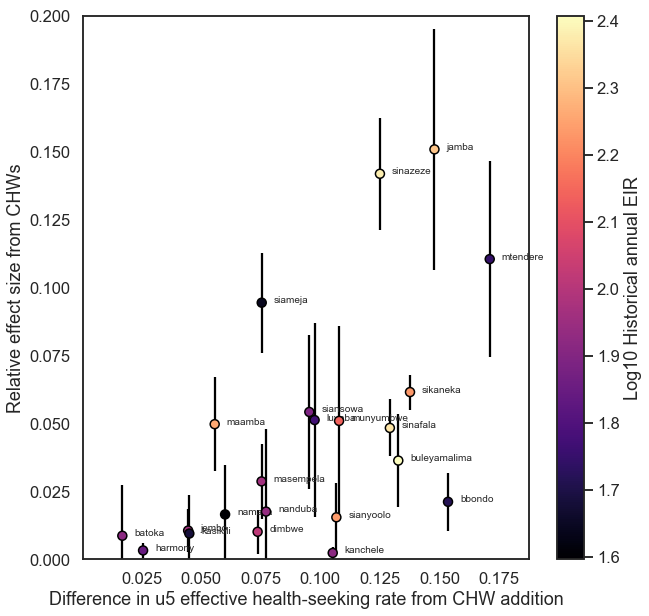

In [286]:
plt.figure(figsize=(10,10))
x = "diff_youth_effhs"
y = "rel_diff_EIR"
yerr = "rel_diff_EIR_std"
c = "historical_annual_EIR"

foo = cov_df.merge(int_dict_2["No CHW"],on="catch",how="left")
# sns.scatterplot("mda_total_cov","rel_diff_EIR",data=foo,zorder=5,hue="irs_max_kill")
plt.scatter(foo[x],foo[y],c=np.log10(foo[c]),edgecolors='black',linestyle='None',cmap='magma',zorder=5)
plt.colorbar(label="Log10 Historical annual EIR")
plt.errorbar(foo[x],foo[y],yerr=foo[yerr],linestyle='None',color='black')
label_point(foo.diff_youth_effhs, foo.rel_diff_EIR, foo.catch, plt.gca(),x_offset=0.005)
plt.ylim([0,0.2])
plt.ylabel("Relative effect size from CHWs")
plt.xlabel("Difference in u5 effective health-seeking rate from CHW addition")

Text(0.5, 0, 'HS impact')

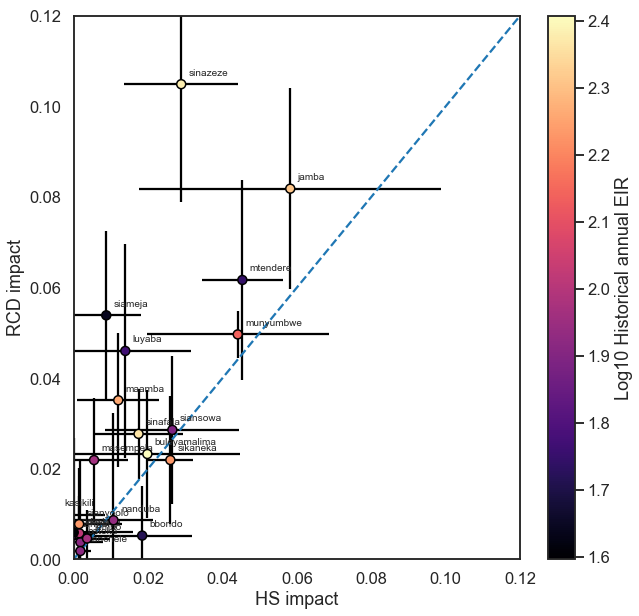

In [298]:
plt.figure(figsize=(10,10))
x = "diff_youth_effhs"
y = "rel_diff_EIR"
yerr = "rel_diff_EIR_std"
c = "historical_annual_EIR"
foo1 = cov_df.merge(int_dict_2["No CHW HS"],on="catch",how="left")
foo2 = cov_df.merge(int_dict_2["No CHW RCD"],on="catch",how="left")

plt.scatter(foo1[y],foo2[y],c=np.log10(foo1[c]),edgecolors='black',linestyle='None',cmap='magma',zorder=5)
plt.colorbar(label="Log10 Historical annual EIR")
plt.errorbar(foo1[y],foo2[y],xerr=foo1[yerr],yerr=foo2[yerr],linestyle='None',color='black')
label_point(foo1.rel_diff_EIR, foo2.rel_diff_EIR, foo1.catch, plt.gca(),x_offset=0.002, y_offset=0.002)
# plt.ylim([0,0.2])
plt.plot([0,1],[0,1],linestyle='dashed')
plt.xlim([0,0.12])
plt.ylim([0,0.12])
plt.ylabel("RCD impact")
plt.xlabel("HS impact")

Text(0, 0.5, 'Full CHW impact')

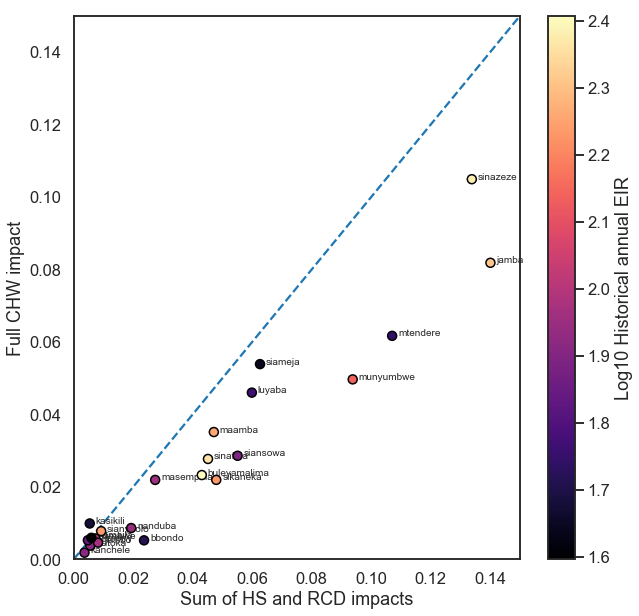

In [308]:
plt.figure(figsize=(10,10))
x = "diff_youth_effhs"
y = "rel_diff_EIR"
yerr = "rel_diff_EIR_std"
c = "historical_annual_EIR"
foo1 = cov_df.merge(int_dict_2["No CHW HS"],on="catch",how="left")
foo2 = cov_df.merge(int_dict_2["No CHW RCD"],on="catch",how="left")
foo3 = cov_df.merge(int_dict_2["No CHW RCD"],on="catch",how="left")

plt.scatter(foo1[y]+foo2[y],foo3[y],c=np.log10(foo1[c]),edgecolors='black',linestyle='None',cmap='magma',zorder=5)
plt.colorbar(label="Log10 Historical annual EIR")
# plt.errorbar(foo1[y],foo2[y],xerr=foo1[yerr],yerr=foo2[yerr],linestyle='None',color='black')
label_point(foo1.rel_diff_EIR+foo2.rel_diff_EIR, foo3.rel_diff_EIR, foo1.catch, plt.gca(),x_offset=0.002)
# plt.ylim([0,0.2])
plt.plot([0,1],[0,1],linestyle='dashed')
plt.xlim([0,0.15])
plt.ylim([0,0.15])
plt.xlabel("Sum of HS and RCD impacts")
plt.ylabel("Full CHW impact")
